In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Converting to DF measurement
measurement_df = pd.read_sql("SELECT * FROM Measurement", conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [10]:
# Converting to DF station
station_df = pd.read_sql("SELECT * FROM Station", conn)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date_point= session.query(func.max(Measurement.date)).scalar()
print(recent_date_point)

2017-08-23


In [12]:
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days= 365)
print(year_ago)

2016-08-23


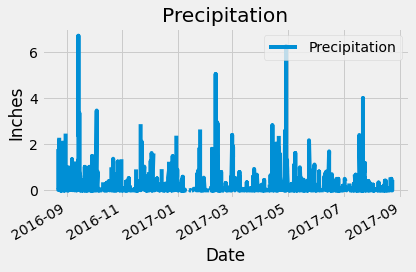

In [13]:
# Perform a query to retrieve the data and precipitation scores
pdata = [Measurement.date, Measurement.prcp]
prcp_data = session.query(*pdata).\
    filter(Measurement.date <= recent_date_point).\
    filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])
clean_prcp_df = prcp_df[prcp_df.Precipitation != 'NaN']
clean_prcp_df.dtypes
clean_prcp_df['Date']= pd.to_datetime(clean_prcp_df['Date'])

# Sort the dataframe by date
clean_prcp_dfindex=clean_prcp_df.set_index('Date')
clean_prcp_dfindex.head()

# Use Pandas Plotting with Matplotlib to plot the data
clean_prcp_dfindex.plot(kind="line")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation")
plt.tight_layout()

# Show Plot
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
clean_prcp_dfindex.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station).group_by(Station.station).count()
stations

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min = session.query(func.min(Measurement.tobs)).all()
max = session.query(func.max(Measurement.tobs)).all()
avg = session.query(func.avg(Measurement.tobs)).all()

print(min, max, avg)

[(53.0,)] [(87.0,)] [(73.09795396419437,)]


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tdata = [Measurement.date, Measurement.tobs, Measurement.station]

temp_data = session.query(*tdata).\
    filter(Measurement.station=='USC00519281').\
    filter(Measurement.date <= recent_date_point).\
    filter(Measurement.date >= year_ago).all()
temp_data_df = pd.DataFrame(temp_data)
temp_data_df.head()

,date,tobs,station
0,2016-08-23,77.0,USC00519281
1,2016-08-24,77.0,USC00519281
2,2016-08-25,80.0,USC00519281
3,2016-08-26,80.0,USC00519281
4,2016-08-27,75.0,USC00519281


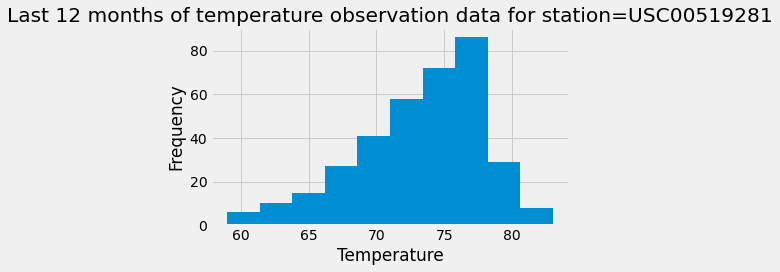

In [19]:
# Plot results
tobs = temp_data_df['tobs']
plt.hist(tobs)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title("Last 12 months of temperature observation data for station=USC00519281")
plt.tight_layout()

# Show Plot
plt.show()

# Close session

In [20]:
# Close Session
session.close()

# Bonus: Temperature Analysis I

### Compare June and December data across all years 

In [21]:
import pandas as pd
from datetime import datetime as dt
from scipy import stats

In [22]:
hawaii_measurements=pd.read_csv('Resources/hawaii_measurements.csv')
hawaii_stations=pd.read_csv('Resources/hawaii_stations.csv')
hawaii_measurements.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [23]:
# Convert the date column format from string to datetime
# Set the date column as the DataFrame index
# Drop the date column
# Filter data for desired months
avg_june_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='06'].groupby(hawaii_measurements['station']).mean()
avg_dec_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='12'].groupby(hawaii_measurements['station']).mean()

In [24]:
# Identify the average temperature for June
avg_june_temp['tobs']

station
USC00511918    74.139394
USC00513117    74.050847
USC00514830    76.005376
USC00516128    71.937220
USC00517948    76.655405
USC00518838    73.394737
USC00519281    73.271186
USC00519397    77.559322
USC00519523    76.668103
Name: tobs, dtype: float64

In [25]:
# Identify the average temperature for December
avg_dec_temp['tobs']

station
USC00511918    69.684211
USC00513117    71.069444
USC00514830    73.224719
USC00516128    69.291262
USC00517948    71.834862
USC00518838    72.421053
USC00519281    69.903226
USC00519397    71.109524
USC00519523    72.433333
Name: tobs, dtype: float64

In [26]:
# Run paired t-test
stats.ttest_ind(avg_june_temp['tobs'], avg_dec_temp['tobs'], equal_var=False)

Ttest_indResult(statistic=4.615865424404701, pvalue=0.0003657335214469917)

### Analysis

There is a very low p-value. From a statistical standpoint, June and December average only a slight difference of about 4 to 5 degrees from each other.

## Bonus Challenge Assignment: Temperature Analysis II

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-01-01'
end_date = '2017-01-07'
temp_result = calc_temps(start_date,end_date)[0]
temp_result

(62.0, 68.36585365853658, 74.0)

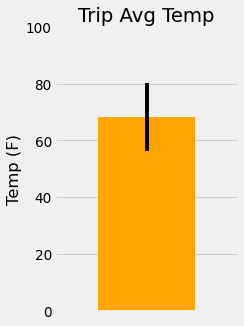

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [temp_result[1]]
error = [(temp_result[2] - temp_result[0])]

w = 3
h = 5
d = 70
plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='orange', yerr=error)
plt.xlim(-0.75,0.75)

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)

plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')

# Show Plot
plt.show()

### Daily Rainfall Average

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-01-01'
end_date = '2017-01-07'

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
queryresult = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
stations = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation','Precipitation'])
stations

,Station,Name,Latitude,Longitude,Elevation,Precipitation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.60
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.60
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.20
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


In [31]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
start_date = daily_normals("04-15")
end_date = daily_normals("04-25")

# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
trip_start_date = "2017-04-15"
trip_end_date = "2017-04-25"
# Use the start and end date to create a range of dates
date_range = session.query(Measurement.date).\
             filter(Measurement.date >= trip_start_date).\
             filter(Measurement.date <= trip_end_date).\
             group_by(Measurement.date).all()
date_range

import datetime as dt

# Strip off the year and save a list of strings in the format %m-%d
stripped_date = list(map(lambda x: dt.datetime.strptime(x[0], '%Y-%m-%d').strftime('%m-%d') , date_range))
stripped_date

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_date = [daily_normals(x)[0] for x in stripped_date]
trip_date

[(61.0, 71.79310344827586, 79.0),
 (62.0, 71.55357142857143, 81.0),
 (65.0, 71.93103448275862, 77.0),
 (67.0, 72.49152542372882, 77.0),
 (65.0, 72.42105263157895, 83.0),
 (64.0, 72.73684210526316, 80.0),
 (66.0, 72.32142857142857, 78.0),
 (65.0, 72.92727272727272, 84.0),
 (65.0, 73.01818181818182, 79.0),
 (67.0, 73.3103448275862, 80.0),
 (66.0, 73.96551724137932, 83.0)]

In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trips_df = pd.DataFrame(trip_date,columns=['Temp Min', 'Temp Avg', 'Temp Max'])
mapped_dates= list(map(lambda x: x[0], date_range))
trips_df['Date'] = mapped_dates
trips_df

,Temp Min,Temp Avg,Temp Max,Date
0,61.0,71.793103,79.0,2017-04-15
1,62.0,71.553571,81.0,2017-04-16
2,65.0,71.931034,77.0,2017-04-17
3,67.0,72.491525,77.0,2017-04-18
4,65.0,72.421053,83.0,2017-04-19
5,64.0,72.736842,80.0,2017-04-20
6,66.0,72.321429,78.0,2017-04-21
7,65.0,72.927273,84.0,2017-04-22
8,65.0,73.018182,79.0,2017-04-23
9,67.0,73.310345,80.0,2017-04-24


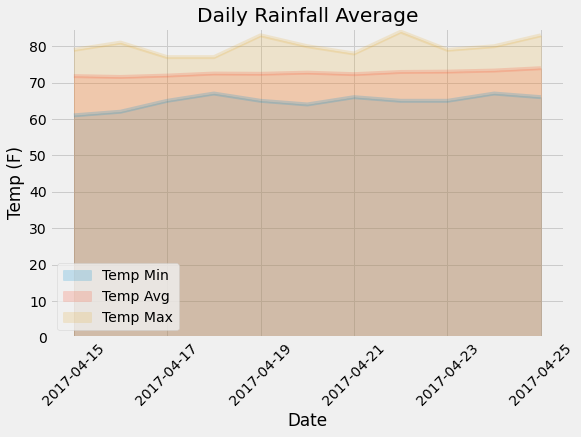

In [34]:
# Plot the daily normals as an area plot with `stacked=False`
trips_df.plot('Date',kind='area',stacked=False,alpha = 0.2,figsize=(8,6))
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0,85)
plt.xlabel('Date')
plt.ylabel('Temp (F)')
plt.title('Daily Rainfall Average')

# Show Plot
plt.show()

## Close Session

In [35]:
# Close Session
session.close()